In [1]:
from plotArgs import *

# Fig. 1 Structurome Overview

## Overall structure

In [5]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx')
df_OvallStrucGini = df[['GENE_ID', 'length', 'GENE_name', 'Merged_Gene_gini']].dropna()
df_OvallStrucGini[df_OvallStrucGini['GENE_name'].isin(['COX8', 'HAC1'])]

,GENE_ID,length,GENE_name,Merged_Gene_gini
1986,YFL031W,969.0,HAC1,0.474252
4468,YLR395C,237.0,COX8,0.235658


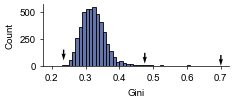

In [11]:
# 18S rRNA: 0.7; 25S rRNA 0.74
plt.figure(figsize=(2.4, 0.8))
plt.hist(df_OvallStrucGini['Merged_Gene_gini'], bins = [i/100 for i in range(20,70)],
         linewidth = 0.6, edgecolor = 'black', color = '#6475AC')

plt.quiver(0.7, 100, 0, -100, angles='xy', scale_units='xy', scale=1)
plt.quiver(0.235, 150, 0, -100, angles='xy', scale_units='xy', scale=1)
plt.quiver(0.475, 120, 0, -100, angles='xy', scale_units='xy', scale=1)
# plt.quiver(0.245, 150, 0, -100, angles='xy', scale_units='xy', scale=1)

plt.xticks([0.2, 0.3, .4, .5, .6, .7])
plt.yticks([0, 250, 500])
plt.xlabel('Gini')
plt.ylabel('Count')
# plt.savefig('5_Figure/Fig1-b.pdf', bbox_inches = 'tight')
plt.show()

## structure examples

### Overall structures

In [79]:
# merge data from all stages
tps = ['YPD', '0h', '6h',  '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
df = pd.read_table('3_Table/shapemapper_YPDNormalized.txt')
df = df[['Modified_mutations', 'Modified_effective_depth', 'Untreated_mutations',
       'Untreated_effective_depth']]
for t in tps[1:]:
    df2 = pd.read_table('3_Table/shapemapper_'+ t +'Normalized.txt')
    df2 = df2[['Modified_mutations', 'Modified_effective_depth', 'Untreated_mutations',
       'Untreated_effective_depth']]
    df = df + df2
    

# calculate reactivity for overall structure
dfseq = pd.read_table('3_Table/shapemapper_YPDNormalized.txt')
df['Nucleotide'] = dfseq['Nucleotide']
df['Sequence'] = dfseq['Sequence']
df['depth'] = df[['Modified_effective_depth', 'Untreated_effective_depth']].min(axis = 1)

df['Modified_rate'] = df.Modified_mutations / df.Modified_effective_depth
df['Untreated_rate'] = df.Untreated_mutations / df.Untreated_effective_depth
df['Reactivity_profile'] = df['Modified_rate'] - df['Untreated_rate']
df['std_err'] = (((df.Modified_rate)**0.5 / (df.Modified_effective_depth)**0.5)**2 + ((df.Untreated_rate)**0.5 / (df.Untreated_effective_depth)**0.5)**2)**0.5


df['HQ_profile'] = df['Reactivity_profile']
df['HQ_stderr'] = df['std_err']

df.loc[df.Reactivity_profile < 0, 'HQ_profile'] = 0
df.loc[df.Reactivity_profile == 0, 'HQ_stderr'] = 0

# only keep DMS reactivitiy at A,C bases
df.loc[df.Sequence.isin(['G', 'U']), 'HQ_profile'] = 0
df.loc[df.Sequence.isin(['G', 'U']), 'HQ_stderr'] = 0

# control mutation rate needs to be < 0.05
df.loc[(df.Untreated_rate > 0.05), 'HQ_profile'] = np.nan
df.loc[(df.Untreated_rate > 0.05), 'HQ_stderr'] = np.nan

# assign position information
dfsite = pd.read_csv('3_Table/Assigned_metagene_seq.csv')
df = pd.merge(df, dfsite[['Nucleotide', 'Gene', 'Pos',  'site_from_start_codon', 'site_from_end_codon']], on='Nucleotide')

# DMS reactivity was normalized by transcript
def nor2(pos):
    if pos.name in df3.index:
        return pos / df3[pos.name]
    else:
        return pos*np.nan

# 90%-95% top reactivity
df2 = df[(df.depth > 350) & df.Sequence.isin(['A', 'C'])].dropna()
df3 = df2.groupby('Gene')['HQ_profile'].apply(lambda x: x[(x > x.quantile(0.9)) & (x < x.quantile(0.95))].mean())

# normalization
df['Reactivity_norby90_95quantile'] = df.groupby('Gene')['HQ_profile'].apply(nor2)
df['Stderr_norby90_95quantile'] = df.groupby('Gene')['HQ_stderr'].apply(nor2)

df.to_csv('3_Table/shapemapper_9sampleNormalized_transcripts.csv')

In [5]:
df_allReact = pd.read_csv('3_Table/shapemapper_9sampleNormalized_transcripts.csv')

In [54]:
# function to export .shape and .map file
def shape(df, file):
    dfshape = df[['Sequence', 'Reactivity_norby90_95quantile', 'Stderr_norby90_95quantile']]
    dfshape.loc[dfshape.Reactivity_norby90_95quantile.isna(), 'Reactivity_norby90_95quantile'] = -999
    dfshape.loc[dfshape.Sequence.isin(['G', 'U']), 'Reactivity_norby90_95quantile'] = -999
    dfshape.index = dfshape.reset_index().index + 1
    dfshape[['Reactivity_norby90_95quantile']].to_csv(file + '_merged' + '.shape', header=False, sep = '\t')
    
def shape_vaRNA(df, file):
    dfshape = df[['Sequence', 'Reactivity_norby90_95quantile', 'Stderr_norby90_95quantile']]
    dfshape['Reactivity_norby90_95quantile'] = dfshape['Reactivity_norby90_95quantile'] + 0.01
    dfshape.loc[dfshape.Sequence.isin(['G', 'U']), 'Reactivity_norby90_95quantile'] = 0
    dfshape.loc[dfshape.Reactivity_norby90_95quantile.isna(), 'Reactivity_norby90_95quantile'] = 0
    dfshape.index = dfshape.reset_index().index + 1
    dfshape[['Reactivity_norby90_95quantile']].to_csv(file + '_merged' + '_vaRNA.shape', header=False, sep = '\t')

# map
# nucleotide number, SHAPE reactivity, Error, Nucleotide sequence.
def map(df, file):
    dfshape = df[['Sequence', 'Reactivity_norby90_95quantile', 'Stderr_norby90_95quantile']]
    dfshape.loc[dfshape.Reactivity_norby90_95quantile.isna(), 'Reactivity_norby90_95quantile'] = -999
    dfshape.loc[dfshape.Reactivity_norby90_95quantile.isna(), 'Stderr_norby90_95quantile'] = -999
    dfshape.loc[dfshape.Sequence.isin(['G', 'U']), 'Reactivity_norby90_95quantile'] = -999
    dfshape.loc[dfshape.Sequence.isin(['G', 'U']), 'Stderr_norby90_95quantile'] = -999
    dfshape.index = dfshape.reset_index().index + 1
    dfshape[['Reactivity_norby90_95quantile', 'Stderr_norby90_95quantile', 'Sequence']].to_csv(file + '_merged' + '.map', header=False, sep = '\t')

### COX8 / YLR395C Overview

In [112]:
df_allReact_COX8= df_allReact[df_allReact.Gene == 'YLR395C']
df_allReact_COX8 = df_allReact_COX8[df_allReact_COX8.depth > 350]
df_allReact_COX8 = df_allReact_COX8[df_allReact_COX8.Sequence.isin(['A', 'C'])].dropna()

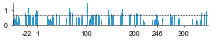

In [138]:
fig, ax = plt.subplots(1, figsize=[3.5, 0.4],sharex=True, sharey=True)
x = df_allReact_COX8.site_from_start_codon
y = df_allReact_COX8['Reactivity_norby90_95quantile']

ax.bar(x,y, color='#3399CC', )
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('none')
ax.axhline(0.7, 0, 1, color = 'k', linestyle = '--', linewidth = 0.5)
plt.xlim(-50, 350)
plt.ylim(0, 1.5)
plt.xticks([-22, 0, 100, 200, 246, 300], [-22, 1, 100, 200, 246, 300])
plt.savefig('5_Figure/Fig1-c COX8 reactivity.pdf')
plt.show()

In [62]:
# 导出Reactivity，模拟结构
shape(df_allReact_COX8.loc[7253145:7253567], '3_Table/COX8')
shape_vaRNA(df_allReact_COX8.loc[7253145:7253567], '3_Table/COX8')
map(df_allReact_COX8.loc[7253145:7253567], '3_Table/COX8')

A = ''.join(df_allReact_COX8.loc[7253145:7253567].Sequence.to_list())
# 303.15
A[21:290]

'AGUUAUCCAUUUCCAUUACGCAAUGUUGUGCCAACAGAUGAUUAGAACGACAGCUAAGAGAAGUAGCAAUAUCAUGACCAGACCUAUUAUCAUGAAGAGGUCAGUACACUUCAAAGACGGUGUGUAUGAAAAUAUCCCAUUCAAAGUCAAAGGAAGAAAGACACCUUACGCCUUAUCUCAUUUCGGGUUCUUCGCUAUUGGAUUUGCUGUUCCAUUUGUUGCCUGCUAUGUUCAAUUGAAAAAGUCAGGUGCUUUUUAAAACACCCCCA'

In [58]:
# 结果
B = '......(.................................(........)..(((((((((....(...(.(.((((.......)))).............(((((............)))))..((((((........))))))...(.............)........(((.....((....))....)))...................................).)))))))))))..........................((((.((.....))))))...........).(.(((.(((((((((((.(((......(.((.((((...............)))).)).)...))).)))))))))))))).).........................................'
B[21:290]
shape_vaRNA(df_allReact_COX8.loc[7253145+21:7253145+289], '3_Table/COX8_example')

### HAC1 / YFL031W Overview

In [82]:
df_HAC1 = pd.read_csv('3_Table/HAC1_500nt.csv')

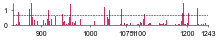

In [129]:
fig, ax = plt.subplots(1, figsize=[3.5, 0.4],sharex=True, sharey=True)
x = df_HAC1.pos
y = df_HAC1['Reactivity_norby90_95quantile']

ax.bar(x,y, color='#CC3366', )
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('none')
ax.axhline(0.7, 0, 1, color = 'k', linestyle = '--', linewidth = 0.5)
plt.xlim(842, 1242)
plt.ylim(0,1.5)
plt.xticks([ 900, 1000, 1075, 1100, 1200, 1243])
plt.savefig('5_Figure/Fig1-c HAC1 reactivity.pdf', bbox_inches = 'tight')
plt.show()

In [105]:
df_allReact_HAC1 = pd.read_table('3_Table/HAC1/shapemapper_allNormalized_transcripts.txt')

In [ ]:
# 1075 - 1243
A = "CUCCGGUUAGUGUUUGCUACUUCAACCGAAGAAGAAGAGGCUUUUCAAGAAUGCAAACGUGAGGUUGGCGCGCCCUCCUACAAUUAUUUGUGGCGACUGGGCAGCGACACUGAACAUAGCUCUUGAACAAGACCCUUUUUUGGCUGCAAGGAGCAAGACUGGCUGGGG"

In [107]:
''.join(df_allReact_HAC1.Sequence.to_list()).index(A)

1575

## Stage sepecific structures

In [2]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx')
dfplot = df[[i for i in df.columns if i.startswith('Gene_gini_')]]

In [14]:
p_values = []
for i in range(dfplot.shape[1] - 1):
    p_values.append(stats.mannwhitneyu(dfplot[dfplot.columns[i]].dropna(), \
        dfplot[dfplot.columns[i+1]].dropna()) )
p_values = [i[1] for i in p_values]

p_adjusted_bonferroni = multipletests(p_values, method='bonferroni')
p_adjusted_bh = multipletests(p_values, method='fdr_bh')
print(p_adjusted_bh)

(array([ True,  True, False, False,  True,  True,  True, False]), array([4.72250541e-045, 5.56966565e-108, 6.04239469e-002, 8.49037903e-001,
       1.72359109e-131, 9.77738258e-003, 5.23381521e-005, 5.30038808e-001]), 0.006391150954545011, 0.00625)


In [4]:
stageGenes = dfplot.apply(lambda x: x.dropna().index.to_list())
tps = ['V','P','T0','T1','T2','T3','T4','T5','T6']
for i in range(stageGenes.shape[0]-1):
    olGenes = len([j for j in stageGenes[i+1] if j in stageGenes[i]])
    spGenes = len([j for j in stageGenes[i+1] if j not in stageGenes[i]])
    ttGenes = olGenes + spGenes
    print(tps[i+1], olGenes, olGenes/ttGenes, spGenes, spGenes/ttGenes)

P 657 0.5465890183028286 545 0.45341098169717137
T0 1016 0.6102102102102102 649 0.3897897897897898
T1 1217 0.8054268696227663 294 0.19457313037723362
T2 1427 0.8643246517262265 224 0.13567534827377348
T3 1020 0.9272727272727272 80 0.07272727272727272
T4 875 0.6410256410256411 490 0.358974358974359
T5 1147 0.9695688926458157 36 0.030431107354184278
T6 989 0.931261770244821 73 0.0687382297551789


/var/folders/rw/85k6y2vs37x81n21hjm129fm0000gn/T/ipykernel_72577/451033608.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  olGenes = len([j for j in stageGenes[i+1] if j in stageGenes[i]])
/var/folders/rw/85k6y2vs37x81n21hjm129fm0000gn/T/ipykernel_72577/451033608.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spGenes = len([j for j in stageGenes[i+1] if j not in stageGenes[i]])


In [10]:
def plot_sig(xstart,xend, yend, sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend), \
        color="black", ha='center')

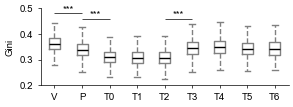

In [13]:
# Setting up figure and style parameters
plt.figure(figsize=(3.2, 1))
props = {
    'boxprops': dict(linestyle='-', linewidth=1, color='gray', alpha=1),
    'medianprops': dict(linestyle='-', linewidth=1, color='k'),
    'whiskerprops': dict(linestyle='--', linewidth=1, color='gray', alpha=1),
    'capprops': dict(linestyle='-', linewidth=1, color='gray', alpha=1)
}

# Plotting the boxplot
dfplot.boxplot(showfliers=False, widths=0.4, **props)

# Configuring axes
ax = plt.gca()
ax.set_xticklabels(['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6'], rotation=0)

ax.set_ylabel('Gini')
ax.grid(False)

plot_sig(1, 2, 0.48, '***')
plot_sig(2, 3, 0.46, '***')
plot_sig(5, 6, 0.46, '***')

ax.set_yticks([0.2, 0.3, 0.4, 0.5])
plt.savefig('5_Figure/Fig1-f boxplot_gini_distribution_with statistic test.pdf',  bbox_inches = 'tight')

# Displaying the plot
plt.show()

## s1-a Meiotic staging

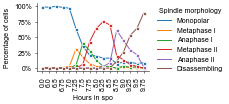

In [76]:
df_stg = pd.read_excel('3_Table/Meiotic staging.xlsx', sheet_name='A14201')
df_stg['times'] = [str(i) for i in df_stg['times']]
df_stg = df_stg[df_stg.Phase.isin(['Anaphase I',
 'Anaphase II',
 'Disassembling',
 'Metaphase I',
 'Metaphase II',
 'Monopolar'])]

plt.figure(figsize = (2, 1.25))
# palette = ['#ffa800ff', '#ff5555ae', '#ff5555ff', '#ff0000ff', '#aa0000ff', '#12037bff']
sns.lineplot(x = 'times', y = 'Rate', hue = 'Phase', data = df_stg, marker = 's', markersize = 3)


leg = plt.legend(loc = (1.05, -0.05),  title = 'Spindle morphology', frameon=False)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# plt.setp(leg_lines)
# plt.setp(leg.get_title())

plt.xticks(rotation = 90)
plt.xlabel('Hours in spo')
plt.ylabel('Percentage of cells')
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0%', '25%', '50%', '75%', '100%'])
plt.savefig('5_Figure/Figs1 A14201_IF counts.pdf', bbox_inches = 'tight')
plt.show()

# Fig2 meiotic RNA structure features

## Gini compare

In [2]:
# dfgc = pd.read_excel('Final_RNA_TE_Gini_MS.xlsx')
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx')
df.loc[df['Meiosis_specific'] != 'yes', 'Meiosis_specific'] = 'no'
# df['ORF_GC_content'] = dfgc['ORF_GC_content']

In [7]:
print(df.loc[df.Meiosis_specific == 'yes', 'Merged_Gene_gini'].dropna().shape)
print(df.loc[df.Meiosis_specific != 'yes', 'Merged_Gene_gini'].dropna().shape)
stats.mannwhitneyu(df.loc[df.Meiosis_specific == 'yes', 'Merged_Gene_gini'].dropna(),
                   df.loc[df.Meiosis_specific != 'yes', 'Merged_Gene_gini'].dropna())

(973,)
(3767,)


MannwhitneyuResult(statistic=1443596.0, pvalue=1.5538735741742618e-24)

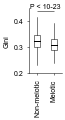

In [23]:
# mpl.rcParams['figure.figsize'] = [1, 0.8]
plt.figure(figsize = (0.6 , 1.2))
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':'0.5'},
    'medianprops':{'color':'k', 'linewidth':'1'},
    'whiskerprops':{'color':'k', 'linewidth':'0.5'},
    'capprops':{'color':'k', 'linewidth' :0}
}

sns.boxplot(x = 'Meiosis_specific',y = 'Merged_Gene_gini', data=df, 
            width=0.35, showfliers = False, **PROPS)

ax = plt.gca()
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.grid(False)

plt.xticks([0,1], ['Non-meiotic', 'Meiotic'], rotation = 90)
plt.yticks([0.2, 0.3, 0.4])
plt.ylim(0.2, 0.45)

plt.ylabel('Gini')

plt.xlabel(None)


def plot_sig(xstart,xend, yend, sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')

plot_sig(0, 1, 0.44, 'P < 10-23')
plt.savefig('5_Figure/fig2-b_boxplot_meiosisRNAs_gini_distribution.pdf',  bbox_inches = 'tight')
plt.show()

In [8]:
print(df.loc[df.RNA_cluster == 'meiotic-early', 'Merged_Gene_gini'].dropna().shape)
print(df.loc[df.RNA_cluster == 'meiotic-late', 'Merged_Gene_gini'].dropna().shape)
stats.mannwhitneyu(df.loc[df.RNA_cluster == 'meiotic-early', 'Merged_Gene_gini'].dropna(),
                   df.loc[df.RNA_cluster == 'meiotic-late', 'Merged_Gene_gini'].dropna())

(251,)
(705,)


MannwhitneyuResult(statistic=81450.0, pvalue=0.06140516998025917)

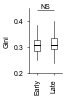

In [24]:
# mpl.rcParams['figure.figsize'] = [1, 0.8]
plt.figure(figsize = (0.6 , 1.2))
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':'0.5'},
    'medianprops':{'color':'k', 'linewidth':'1'},
    'whiskerprops':{'color':'k', 'linewidth':'0.5'},
    'capprops':{'color':'k', 'linewidth' :0}
}

sns.boxplot(x = 'RNA_cluster',y = 'Merged_Gene_gini', data=df,
            width=0.35,showfliers = False,\
           **PROPS, order = ['meiotic-early', 'meiotic-late'])

ax = plt.gca()
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.grid(False)
plt.xticks([0,1], ['Early', 'Late'], rotation = 90)
plt.yticks([0.2, 0.3, 0.4])
plt.ylim(0.2, 0.45)
plt.ylabel('Gini')
plt.xlabel('')

def plot_sig(xstart,xend, yend,sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')
plot_sig(0, 1, 0.44, 'NS')
plt.savefig('5_Figure/fig2-c_boxplot_early_vs_late.pdf',  bbox_inches = 'tight')
plt.show()

## metagene analysis

In [ ]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx')
# dftps = pd.read_csv('3_Table/shapemapper_9sampleNormalized_transcripts.csv')
# dftps = dftps[(dftps.depth > 350)]

In [134]:
df1 = pd.read_csv('3_Table/meta_5utr_meiotics_AUGC.csv')
df2 = pd.read_csv('3_Table/meta_5utr_others_AUGC.csv')
df3 = pd.read_csv('3_Table/meta_3utr_meiotics_AUGC.csv')
df4 = pd.read_csv('3_Table/meta_3utr_others_AUGC.csv')

df1 = df1[(df1.position >= -100) & (df1.position <= 150)]
df2 = df2[(df2.position >= -100) & (df2.position <= 150)]
df3 = df3[(df3.position >= -150) & (df3.position <= 100)]
df4 = df4[(df4.position >= -150) & (df4.position <= 100)]

df1['x'] = df1.position
df3['x'] = df3.position + 400
# df1 = pd.concat([df1, df3])

df2['x'] = df2.position
df4['x'] = df4.position + 400

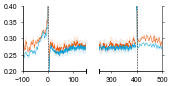

In [159]:
# meiotic vs Others
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(2.5, 1.2))
# fig.subplots_adjust(wspace=0.05)

# ax1,ax3 - is the left subplot
# ax2,ax4 - is the right subplot
# prepare twinned axes
ax3 = ax1.twinx()
ax4 = ax2.twinx()

ax1.set_xlim(-100, 150)
ax2.set_xlim(250, 500)
ax3.set_xlim(-100, 150)
ax4.set_xlim(250, 500)

y1max = 0.4
y1min = 0.2
y2max = 0.4
y2min = 0.2
linewidth = 0.5
ax1.set_ylim(y1min, y1max)
ax3.set_ylim(y2min, y2max)
# ax4.set_ylim(y2min, y2max)

# turn off spines
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(True)

ax3.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax1.tick_params(right=False)
ax3.yaxis.set_visible(False)

ax2.tick_params(left = False)
ax2.tick_params(right = True)
ax4.tick_params(right = False)
ax4.yaxis.set_visible(False)

# plotting break diagonals
d = 0.025  # line length 
ax1.plot((1, 1), (-d, +d), c='k', clip_on=False, transform=ax1.transAxes)
ax2.plot((0, 0), (-d, d), c='k', clip_on=False, transform=ax2.transAxes)

linewidth1 = 0.4
# meiosis-specific
ax1.plot(df1['x'], df1['React_5nt'], c='#EA5404', label='meiotic',zorder = 1, linewidth = linewidth1)
ax2.plot(df3['x'], df3['React_5nt'], c='#EA5404', label='meiotic', zorder = 1, linewidth = linewidth1)
ax1.fill_between(df1['x'], df1.React_5nt + df1.err_5nt,  df1.React_5nt - df1.err_5nt,\
                 color='#FCEEE6', edgecolor='#F9D5C2', zorder = 1, linewidth = linewidth1, alpha = 0.5)
ax2.fill_between(df3['x'], df3.React_5nt + df3.err_5nt,  df3.React_5nt - df3.err_5nt, \
                 color='#FCEEE6', edgecolor='#F9D5C2', zorder = 1, linewidth = linewidth1, alpha = 0.5)

# non-meiosis
ax1.plot(df2['x'], df2['React_5nt'], c='#009FDA', label='non-meiotic', linewidth = linewidth1)
ax2.plot(df4['x'], df4['React_5nt'], c='#009FDA', label='non-meiotic', linewidth = linewidth1)
ax1.fill_between(df2['x'], df2.React_5nt + df2.err_5nt,  df2.React_5nt - df2.err_5nt,\
                 color='#E9F6FC', edgecolor='#D0EDF7', linewidth = linewidth1, alpha = 0.5)
ax2.fill_between(df4['x'], df4.React_5nt + df4.err_5nt,  df4.React_5nt - df4.err_5nt,\
                 color='#E9F6FC', edgecolor='#D0EDF7', linewidth = linewidth1, alpha = 0.5)


# ax1.legend(loc = (0.5, 0.8))

ax1.vlines(x=1, ymin=y1min, ymax=y1max,  color = 'black', linestyle = '--', zorder = 100, linewidth = linewidth)
# ax1.vlines(x=100, ymin=y1min, ymax=y1max,  color = 'gray', linestyle = '--', zorder = 100, linewidth = linewidth)
ax2.vlines(x=400, ymin=y1min, ymax=y1max,  color = 'black', linestyle = '--', zorder = 100, linewidth = linewidth)
# ax2.vlines(x=300, ymin=y1min, ymax=y1max,  color = 'gray', linestyle = '--', zorder = 100, linewidth = linewidth)

plt.savefig('5_Figure/fig2-c meta_meiotic vs others_AUGC.pdf', bbox_inches = 'tight')
plt.show()

## strutcure vs TE

### match up

In [132]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')
tps = ['YPD', '0h', '6h', '7h','7h25', '7h5','8h25', '8h75', '9h5']
matchup = {'YPD':'YPD', '0h': '0h', '6h':'6h', '7h':'7h', '7h25':'7h25', '7h5':'7h5', '8h25':'8h', '8h75': '8h5', '9h5':'9h25'}

dfgini = df[[i for i in df.columns if i.startswith('ORF_gini_')]]
dfgini.columns = tps

tpsbrar = ['YPD', '0h', '6h', '6h5', '6h75', '7h', '7h25', '7h5', '7h75', '8h', '8h25', '8h5', '8h75', '9h25', '11h']
dfRNA = df[[i for i in df.columns if i.startswith('RNA_brar_')]]
dfRNA.columns = tpsbrar
dfribo = df[[i for i in df.columns if i.startswith('Ribo_brar_')]]
dfribo.columns = tpsbrar

dfte = dfribo[dfribo>=5] / dfRNA[dfRNA>=5]
# dfte = dfribo / dfRNA[dfRNA>=1]

dfte = dfte[[matchup[i] for i in tps]]

# convert timepoints
dfte.columns = tps

dftelog = np.log2(dfte)

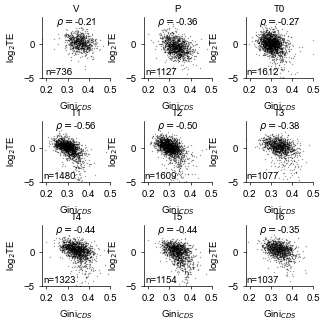

In [37]:
timepoints = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
corr_list = []
tps = ['YPD', '0h', '6h', '7h','7h25', '7h5','8h25', '8h75', '9h5']
fig = plt.figure(figsize = (3.5, 3.5))
fig.subplots_adjust(hspace=0.7, wspace=0.5)
for i in range(9):
    t1 = tps[i]
    t2 = timepoints[i]
    
    ax = plt.subplot(3, 3, i+1)
    g = plt.scatter(dfgini[t1], dftelog[t1], s = 1, color = 'black', alpha = .4, linewidths = 0)
    plt.xlabel(r'Gini$_{CDS}$')
    plt.xlim(0.18, 0.5)
    plt.ylim(-5, 4)
    plt.xticks([0.2, 0.3, 0.4, 0.5])
    plt.ylabel(r'log${_2}$TE')

    dfcorr = pd.DataFrame([dfgini[t1], dftelog[t1]]).reset_index(drop=True).T.dropna()
    corr = stats.spearmanr(dfcorr[0], dfcorr[1])[0]
    corr_list.append(corr)
    
    ax.text(0.5, 0.87, t2+ '\n' +r'$\rho=$' + str(format(corr, '.2f')) , 
             transform=ax.transAxes, ha = 'center')
    ax.text(0.25, 0.05, 'n='+str(dfcorr.shape[0]) , 
             transform=ax.transAxes, ha = 'center')
    
    ax = plt.gca()#获取边框
    spwidth = 0.5
    ax.spines['top'].set_linewidth(0)  
    ax.spines['right'].set_linewidth(0) 
    ax.spines['bottom'].set_linewidth(spwidth)
    ax.spines['left'].set_linewidth(spwidth)

# plt.savefig('5_Figure/Figs2 n2 gini and te spearman corr.pdf', bbox_inches = 'tight')
plt.show()

In [4]:
stats.ttest_ind(corr_list[0:3], corr_list[3:])

TtestResult(statistic=3.03254550854868, pvalue=0.01904607753148016, df=7.0)

In [39]:
dfcorr = pd.DataFrame(columns=['timepoint', 'corr', 'phase'])
timepoints = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']

dfcorr['timepoint'] = timepoints
dfcorr['corr'] = corr_list
dfcorr['abscorr'] = np.abs(corr_list)
dfcorr['phase'] = ['pre', 'pre', 'pre', 'division', 'division', 'division', 'division', 'division', 'division']
# df_unit = dfcorr.groupby('phase').mean().reset_index()

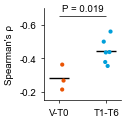

In [40]:
plt.figure(figsize=(1, 1.2))
meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':0},
    'medianprops':{'color':'k', 'linewidth':0},
    'whiskerprops':{'color':'k', 'linewidth':0},
    'capprops':{'color':'k', 'linewidth' : 0},
    'meanprops':{"marker":"_",  "markeredgecolor":"black", "markersize":15}
}
sns.boxplot(x='phase', y='abscorr', data=dfcorr,  **PROPS, width = 0.5, showmeans=True)

sns.stripplot(x='phase', y='abscorr', data=dfcorr, s = 3, hue='phase', palette=['#EA5404', '#009FDA'])
plt.xticks([0,1], ["V-T0", "T1-T6"])
plt.ylim(0.15, 0.7)
plt.yticks([0.2,  0.4,  0.6], [-0.2, -0.4, -0.6])
plt.ylabel('Spearman\'s ρ')
plt.xlabel('')

def plot_sig(xstart,xend, yend,sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.03), color="black", ha='center')
plot_sig(0, 1, 0.65, 'P = 0.019')

# plt.savefig('5_Figure/Fig2-d corr change.pdf', bbox_inches = 'tight')
plt.show()

In [9]:
dfgini['TUMs'] = np.nan
dfgini.loc[dfgini.index.isin(df[df['Meiosis_specific'] == 'yes'].index.to_list()), 'TUMs'] = 'Yes'

dftelog['TUMs'] = np.nan
dftelog.loc[dftelog.index.isin(df[df['Meiosis_specific'] == 'yes'].index.to_list()), 'TUMs'] = 'Yes'

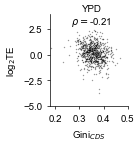

In [4]:
timepoints = ['YPD', '0h', '6h', '7h', '7h25', '7h50',  '8h25', '8h75', '9h5']
i = 0
t1 = tps[i]
t2 = timepoints[i]

plt.figure(figsize=(1, 1.2))
g = plt.scatter(dfgini[t1], dftelog[t1], s = 1, color = 'black', alpha = .4, linewidths = 0)
# plt.scatter(dfgini[dfgini.TUMs != 'Yes'][t1], 
#                 dftelog[dftelog.TUMs != 'Yes'][t1], 
#                 s = 1, color = 'k', alpha = .4, linewidths = 0)
# plt.scatter(dfgini[dfgini.TUMs == 'Yes'][t1], 
#                 dftelog[dftelog.TUMs == 'Yes'][t1], 
#                 s = 1, color = '#EA5404', alpha = .4, linewidths = 0)


plt.xlabel(r'Gini$_{CDS}$')
plt.xlim(0.18, 0.5)
plt.ylim(-5, 4)
plt.xticks([0.2, 0.3, 0.4, 0.5])
plt.ylabel(r'log${_2}$TE')

dfcorr = pd.DataFrame([dfgini[t1], dftelog[t1]]).reset_index(drop=True).T.dropna()
corr = stats.spearmanr(dfcorr[0], dfcorr[1])[0]

plt.text(0.35, 3, t2+ '\n' +r'$\rho=$' + str(format(corr, '.2f')) , ha = 'center')
# ax.text(0.25, 0.05, 'n='+str(dfcorr.shape[0]) , 
#          transform=ax.transAxes, ha = 'center')

ax = plt.gca()
spwidth = 0.5
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.spines['bottom'].set_linewidth(spwidth)
ax.spines['left'].set_linewidth(spwidth)
# plt.savefig('5_Figure/Fig2-d Veg corr.pdf', bbox_inches = 'tight')

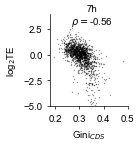

In [5]:
i = 3
t1 = tps[i]
t2 = timepoints[i]

plt.figure(figsize=(1, 1.2))
g = plt.scatter(dfgini[t1], dftelog[t1], s = 1, color = 'black', alpha = .4, linewidths = 0)

# plt.scatter(dfgini[dfgini.TUMs != 'Yes'][t1], 
#                 dftelog[dftelog.TUMs != 'Yes'][t1], 
#                 s = 1, color = 'k', alpha = .4, linewidths = 0)
# plt.scatter(dfgini[dfgini.TUMs == 'Yes'][t1], 
#                 dftelog[dftelog.TUMs == 'Yes'][t1], 
#                 s = 1, color = '#EA5404', alpha = .4, linewidths = 0)

plt.xlabel(r'Gini$_{CDS}$')
plt.xlim(0.18, 0.5)
plt.ylim(-5, 4)
plt.xticks([0.2, 0.3, 0.4, 0.5])
plt.ylabel(r'log${_2}$TE')

dfcorr = pd.DataFrame([dfgini[t1], dftelog[t1]]).reset_index(drop=True).T.dropna()
corr = stats.spearmanr(dfcorr[0], dfcorr[1])[0]

plt.text(0.35, 3, t2+ '\n' +r'$\rho=$' + str(format(corr, '.2f')) , ha = 'center')

ax = plt.gca()#获取边框
spwidth = 0.5
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.spines['bottom'].set_linewidth(spwidth)
ax.spines['left'].set_linewidth(spwidth)
# plt.savefig('5_Figure/Fig2-d T1 corr.pdf', bbox_inches = 'tight')

In [10]:
stats.mannwhitneyu(dftelog[dftelog.TUMs == 'Yes'][t1].dropna(), 
                   dftelog[dftelog.TUMs != 'Yes'][t1].dropna())

MannwhitneyuResult(statistic=2057832.5, pvalue=0.37521653967836766)

In [11]:
stats.ttest_ind(dftelog[dftelog.TUMs == 'Yes'][t1].dropna(), 
                dftelog[dftelog.TUMs != 'Yes'][t1].dropna())

TtestResult(statistic=-1.5405104059097892, pvalue=0.12349664839722306, df=5216.0)

In [15]:
dftelog.columns

Index(['YPD', '0h', '6h', '7h', '7h25', '7h5', '8h25', '8h75', '9h5', 'TUMs'], dtype='object')

In [56]:
stats.ttest_ind(dftelog.loc[dfgini[dfgini.TUMs == 'Yes'][t].dropna().index.to_list(), t].dropna(), 
                dftelog.loc[dfgini[dfgini.TUMs != 'Yes'][t].dropna().index.to_list(), t].dropna())

TtestResult(statistic=-5.435152383410092, pvalue=6.827292903732273e-08, df=1035.0)

In [55]:
2**(dftelog.loc[dfgini[dfgini.TUMs == 'Yes'][t].dropna().index.to_list(), t].dropna().median())

1.1334877400275163

In [54]:
2**(dftelog.loc[dfgini[dfgini.TUMs != 'Yes'][t].dropna().index.to_list(), t].dropna().median())

1.4085588104402131

# Fig3 translation timing and RNA structure

## GO analysis

In [9]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')

In [11]:
dfm = df[df['Meiosis_specific'] == 'yes'].sort_values('Merged_Gene_gini', ascending=False)[['GENE_name', 'Merged_Gene_gini']].dropna()
n = round(dfm.shape[0]/3)
dftop13 = dfm.head(n)
dfbot13 = dfm.tail(n)
dfmod13 = dfm.loc[~dfm.index.isin(dftop13.index.to_list() +  dfbot13.index.to_list())]
print(dftop13.shape, dfmod13.shape, dfbot13.shape)
# with open('3_Table/complex_gene.csv', 'w') as f1:
#     f1.write('\n'.join(dftop13.index.to_list()))

# with open('3_Table/simple_gene.csv', 'w') as f1:
#     f1.write('\n'.join(dfbot13.index.to_list()))
    
# with open('3_Table/moderate_gene.csv', 'w') as f1:
#     f1.write('\n'.join(dfmod13.index.to_list()))

# SDG gene list analysis
# dftop13 = pd.read_table('3_Table/complex gene go_enrichment_for_gene.tsv', header=None)
# dftop13['geneNub'] = [len(i.split(',')) for i in dftop13[2]]
# dftop13.to_excel('3_Table/complex gene go_enrichment_for_gene.xlsx')

# dftop13 = pd.read_table('3_Table/simple gene go_enrichment_for_gene.tsv', header=None)
# dftop13['geneNub'] = [len(i.split(',')) for i in dftop13[2]]
# dftop13.to_excel('3_Table/simple gene go_enrichment_for_gene.xlsx')

# dftop13 = pd.read_table('3_Table/moderate gene go_enrichment_for_gene.tsv', header=None)
# dftop13['geneNub'] = [len(i.split(',')) for i in dftop13[2]]
# dftop13.to_excel('3_Table/moderate gene go_enrichment_for_gene.xlsx')

(324, 2) (325, 2) (324, 2)


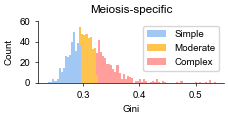

In [59]:
data = dfm['Merged_Gene_gini']

plt.figure(figsize=(2.4, 0.8))
# Computing the quantiles
q1, q2 = np.quantile(data, [1/3, 2/3])

# Separating data into groups based on quantiles
group1 = data[data <= q1]
group2 = data[(data > q1) & (data <= q2)]
group3 = data[data > q2]

# Determine the bin edges for the entire dataset
bins = np.histogram_bin_edges(data, bins=100)

# Creating the stacked histogram
plt.hist([group1, group2, group3], bins=bins, stacked=True, 
         color=['#A1C8F4', '#FFC450', '#FF9E9A'], 
         label=['Simple', 'Moderate', 'Complex'])

# Adding labels and title
plt.xlabel('Gini')
plt.ylabel('Count')
plt.title('Meiosis-specific')
plt.xlim(0.22, 0.55)
plt.ylim(0, 60)
plt.legend()

# Display the histogram
# plt.savefig('5_Figure/fig3-a_distribution.pdf',  bbox_inches = 'tight')
plt.show()

In [60]:
dftop13 = pd.read_excel('3_Table/complex gene go_enrichment_for_gene.xlsx', index_col=0)
dftop13.columns = ['Term', 'Adjusted P-value', 'Genes', 'GO', 'geneNub']
dftop13 = dftop13.reset_index(drop = True)

dfbot13 = pd.read_excel('3_Table/simple gene go_enrichment_for_gene.xlsx', index_col=0)
dfbot13.columns = ['Term', 'Adjusted P-value', 'Genes', 'GO', 'geneNub']
dfbot13 = dfbot13.reset_index(drop = True)

dfmod13 = pd.read_excel('3_Table/moderate gene go_enrichment_for_gene.xlsx', index_col=0)
dfmod13.columns = ['Term', 'Adjusted P-value', 'Genes', 'GO', 'geneNub']
dfmod13 = dfmod13.reset_index(drop = True)

dfgo = pd.concat([dfbot13, dfmod13, dftop13]).reset_index(drop = True)
dfgo['-log10(P-value)'] = -np.log10(dfgo['Adjusted P-value'])

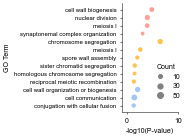

In [253]:
colors = ['#A1C8F4'] * 4 + ["#FFC450"] * 6 + ['#FF9E9A'] * 3
# Creating the plot
fig, ax = plt.subplots(figsize=(1, 2))
sc = ax.scatter(dfgo['-log10(P-value)'], -dfgo.index, s= np.sqrt(dfgo['geneNub'])*5, 
                c=colors, edgecolors='none')

# Creating invisible scatter plots for legend
for i,j in zip([(np.sqrt(10)*5), (np.sqrt(30)*5), (np.sqrt(50)*5)], [10, 30, 50]):  # Change these values based on your data
    ax.scatter([], [], s = i, c='grey', label=str(j))

# Creating the legend for dot sizes
ax.legend(loc = (0.5, 0.1) , scatterpoints=1, frameon=False, labelspacing=0.5, title='Count')

# Adjusting color bar size
# cbar = plt.colorbar(sc, aspect=4, fraction=0.08, pad=0.1)
# cbar.ax.tick_params(labelsize=7) # Adjust fontsize of color bar labels

# Setting x-axis tick labels with 90-degree rotation
ax.set_yticks(-dfgo.index)
ax.set_yticklabels(dfgo['Term'], fontsize = 6)
ax.set_xticks([0, 10, 20])

# Additional customizations
ax.set_ylabel('GO Term')
ax.set_xlabel('-log10(P-value)')

ax.set_xlim(-1, 10)
ax.set_ylim(-12.8, 0.8)
# ax.set_title('GO Enrichment Dot Plot')
plt.savefig('5_Figure/fig3-a_-GO enrichment.pdf',  bbox_inches = 'tight')
plt.show()

## RNA structure diff ( peotein & ribo cluster)

In [ ]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')

In [13]:
print(df.loc[df.Protein_cluster == 'protein1', 'Merged_Gene_gini'].dropna().shape,\
    df.loc[df.Protein_cluster == 'protein2', 'Merged_Gene_gini'].dropna().shape,\
        df.loc[df.Protein_cluster == 'protein3', 'Merged_Gene_gini'].dropna().shape)

(192,) (223,) (104,)


In [13]:
print(stats.mannwhitneyu(df.loc[df.Protein_cluster == 'protein1', 'Merged_Gene_gini'].dropna(),
                   df.loc[df.Protein_cluster == 'protein2', 'Merged_Gene_gini'].dropna()))
print(stats.mannwhitneyu(df.loc[df.Protein_cluster == 'protein2', 'Merged_Gene_gini'].dropna(),
                   df.loc[df.Protein_cluster == 'protein3', 'Merged_Gene_gini'].dropna()))

MannwhitneyuResult(statistic=26779.0, pvalue=1.0426090531581877e-05)
MannwhitneyuResult(statistic=7914.0, pvalue=3.765726797209107e-06)


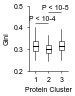

In [17]:
# mpl.rcParams['figure.figsize'] = [1, 0.8]
plt.figure(figsize = (0.7 , 1.2))
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':'0.5'},
    'medianprops':{'color':'k', 'linewidth':'1'},
    'whiskerprops':{'color':'k', 'linewidth':'0.5'},
    'capprops':{'color':'k', 'linewidth' :0}
}

sns.boxplot(x = 'Protein_cluster',y = 'Merged_Gene_gini', data=df, 
            width=0.35, showfliers = False, **PROPS, order = ['protein1', 'protein2', 'protein3'])

ax = plt.gca()
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.grid(False)

plt.xticks([0,1,2], ['1', '2', '3'])
plt.yticks([0.2, 0.3, 0.4, 0.5])
plt.ylim(0.2, 0.5)
# plt.xlim(-0.8, 2.5)

plt.ylabel('Gini')

plt.xlabel('Protein Cluster')


def plot_sig(xstart,xend, yend, sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')

plot_sig(0, 1, 0.42, 'P < 10-4')

plot_sig(1, 2, 0.47, 'P < 10-5')
plt.savefig('5_Figure/fig3-c_boxplot_proteinCluster_gini_distribution.pdf',  bbox_inches = 'tight')
plt.show()

In [14]:
print(df.loc[df.Ribo_cluster == 'ribo1', 'Merged_Gene_gini'].dropna().shape,\
    df.loc[df.Ribo_cluster == 'ribo2', 'Merged_Gene_gini'].dropna().shape,\
        df.loc[df.Ribo_cluster == 'ribo3', 'Merged_Gene_gini'].dropna().shape)

(930,) (268,) (188,)


In [18]:
print(stats.mannwhitneyu(df.loc[df.Ribo_cluster == 'ribo1', 'Merged_Gene_gini'].dropna(),
                   df.loc[df.Ribo_cluster == 'ribo2', 'Merged_Gene_gini'].dropna()))
print(stats.mannwhitneyu(df.loc[df.Ribo_cluster == 'ribo2', 'Merged_Gene_gini'].dropna(),
                   df.loc[df.Ribo_cluster == 'ribo3', 'Merged_Gene_gini'].dropna()))

MannwhitneyuResult(statistic=150832.0, pvalue=1.5006843346572338e-07)
MannwhitneyuResult(statistic=15410.0, pvalue=1.6481700135657936e-12)


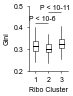

In [20]:
# mpl.rcParams['figure.figsize'] = [1, 0.8]
plt.figure(figsize = (0.7 , 1.2))
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':'0.5'},
    'medianprops':{'color':'k', 'linewidth':'1'},
    'whiskerprops':{'color':'k', 'linewidth':'0.5'},
    'capprops':{'color':'k', 'linewidth' :0}
}

sns.boxplot(x = 'Ribo_cluster',y = 'Merged_Gene_gini', data=df, 
            width=0.35, showfliers = False, **PROPS, order = ['ribo1', 'ribo2', 'ribo3'])

ax = plt.gca()
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.grid(False)

plt.xticks([0,1,2], ['1', '2', '3'])
plt.yticks([0.2, 0.3, 0.4, 0.5])
plt.ylim(0.2, 0.5)
# plt.xlim(-0.8, 2.5)

plt.ylabel('Gini')

plt.xlabel('Ribo Cluster')


def plot_sig(xstart,xend, yend, sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')

plot_sig(0, 1, 0.42, 'P < 10-6')

plot_sig(1, 2, 0.47, 'P < 10-11')
plt.savefig('5_Figure/fig3-c_boxplot_riboCluster_gini_distribution.pdf',  bbox_inches = 'tight')
plt.show()

In [23]:
dfRibo_Protein = pd.DataFrame(df.groupby(['Protein_cluster', 'Ribo_cluster']).size()).reset_index().pivot(columns='Ribo_cluster', index = 'Protein_cluster')
dfRibo_Protein = dfRibo_Protein.loc[['protein1', 'protein2', 'protein3']]
dfRibo_Protein.columns = dfRibo_Protein.columns.droplevel(0)
dfRibo_Protein

Ribo_cluster,ribo1,ribo2,ribo3
Protein_cluster,,,
protein1,102.0,6.0,5.0
protein2,7.0,133.0,9.0
protein3,9.0,13.0,31.0


In [315]:
dfRibo_Protein.to_csv('3_Table/Ribo_Protein_cluster_overlap.csv')

In [ ]:
# Pritein and ribo cluster overlap
# %R
# setwd("E:/Data/Yeast/3_Table/chord plot")
# library(circlize)
# df = read.csv('Ribo_Protein_cluster_overlap.csv', row.names = 'Protein_cluster')
# df = as.matrix(df)
# df = df[c("protein3", "protein2", "protein1"),]

# circos.clear()
# circos.par(start.degree = -15, gap.degree = c(10,10,30,10,10,30)) 
# colors <- c(ribo1 = "#C6C4FC", ribo2 = "#EBEF6D", ribo3 = "#F09E5A", protein3 = "#F09E5A", protein2 = "#EBEF6D", protein1 = "#C6C4FC")

# chordDiagram(df, grid.col = colors, annotationTrack = c("name", "grid"), annotationTrackHeight  = c(0.03, 0.1))

# # add x xias 
# for(si in get.all.sector.index()) {
#     circos.axis(h = "top", labels = FALSE, major.tick = FALSE, sector.index = si, track.index = 2, lwd =2)
# }

# abline(h = 0, lty = 2, col = "gray", lwd = 2)
# circos.clear()


## UTR and ORF account for translation regulation

In [ ]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')

### ORF

In [21]:
col = 'Merged_ORF_gini'
dfplot = df
print(stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna(),
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna()),'\n', 
     stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna(), 
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna()),'\n', 
     stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna(), 
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna()),)

MannwhitneyuResult(statistic=152221.0, pvalue=3.1874686592124184e-08) 
 MannwhitneyuResult(statistic=16276.0, pvalue=1.2247321318086586e-10) 
 MannwhitneyuResult(statistic=75640.0, pvalue=0.0035306881036353157)


In [22]:
print(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna().shape,\
    dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna().shape,\
        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna().shape)

(930,) (268,) (188,)


In [69]:
col = 'Merged_ORF_gini'
print(stats.mannwhitneyu(df.loc[df.Ribo_cluster == 'ribo1', col].dropna(),
                        df.loc[df.Ribo_cluster == 'ribo2', col].dropna()),'\n', 
     stats.mannwhitneyu(df.loc[df.Ribo_cluster == 'ribo2', col].dropna(), 
                        df.loc[df.Ribo_cluster == 'ribo3', col].dropna()),'\n', 
     stats.mannwhitneyu(df.loc[df.Ribo_cluster == 'ribo1', col].dropna(), 
                        df.loc[df.Ribo_cluster == 'ribo3', col].dropna()),)

MannwhitneyuResult(statistic=152221.0, pvalue=3.1874686592124184e-08) 
 MannwhitneyuResult(statistic=16276.0, pvalue=1.224732131808659e-10) 
 MannwhitneyuResult(statistic=75640.0, pvalue=0.003530688103635316)


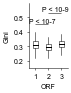

In [103]:
col = 'Merged_ORF_gini'
plt.figure(figsize = (0.7 , 1.2))
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':'0.5'},
    'medianprops':{'color':'k', 'linewidth':'1'},
    'whiskerprops':{'color':'k', 'linewidth':'0.5'},
    'capprops':{'color':'k', 'linewidth' :0}
}

sns.boxplot(x = 'Ribo_cluster',y = col, data=df, 
            width=0.35, showfliers = False, **PROPS, order = ['ribo1', 'ribo2', 'ribo3'])

ax = plt.gca()
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.grid(False)

plt.xticks([0,1,2], ['1', '2', '3'])
plt.yticks([0.2, 0.3, 0.4, 0.5])
# plt.ylim(0.17, 0.55)
plt.ylim(0.15, 0.6)
# plt.ylim(0.2, 0.5)

# plt.xlim(-0.8, 2.5)

plt.ylabel('Gini')
plt.xlabel('ORF')

def plot_sig(xstart,xend, yend, sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')

plot_sig(0, 1, 0.45, 'P < 10-7')
plot_sig(1, 2, 0.53, 'P < 10-9')
plt.savefig('5_Figure/fig3_boxplot_riboCluster_ORFgini_distribution.pdf',  bbox_inches = 'tight')
plt.show()

### 5UTR

In [16]:
col = 'Merged_5utr_gini'
dfplot = df[df['Merged_5utr_AC350'] >= 20]
print(stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna(),
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna()),'\n', 
     stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna(), 
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna()),'\n', 
     stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna(), 
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna()),)

MannwhitneyuResult(statistic=31648.0, pvalue=0.4600640350212113) 
 MannwhitneyuResult(statistic=9292.0, pvalue=0.014632907706367037) 
 MannwhitneyuResult(statistic=17754.0, pvalue=0.0647563377459966)


In [18]:
print(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna().shape,\
    dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna().shape,\
        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna().shape)

(331,) (184,) (121,)


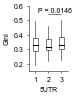

In [90]:
col = 'Merged_5utr_gini'
plt.figure(figsize = (0.7 , 1.2))
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':'0.5'},
    'medianprops':{'color':'k', 'linewidth':'1'},
    'whiskerprops':{'color':'k', 'linewidth':'0.5'},
    'capprops':{'color':'k', 'linewidth' :0}
}

sns.boxplot(x = 'Ribo_cluster',y = col, data=df[df['Merged_5utr_AC350'] >= 20], 
            width=0.35, showfliers = False, **PROPS, order = ['ribo1', 'ribo2', 'ribo3'])

ax = plt.gca()
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.grid(False)

plt.xticks([0,1,2], ['1', '2', '3'])
plt.yticks([0.2, 0.3, 0.4, 0.5, 0.6])
plt.ylim(0.15, 0.6)
# plt.xlim(-0.8, 2.5)

plt.ylabel('Gini')
plt.xlabel('5UTR')

def plot_sig(xstart,xend, yend, sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')

plot_sig(1, 2, 0.54, 'P = 0.0146')
plt.savefig('5_Figure/fig3_boxplot_riboCluster_5UTRgini_distribution.pdf',  bbox_inches = 'tight')
plt.show()

### 3UTR

In [19]:
col = 'Merged_3utr_gini'
dfplot = df[df['Merged_3utr_AC350'] >= 20]
print(stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna(),
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna()),'\n', 
     stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna(), 
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna()),'\n', 
     stats.mannwhitneyu(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna(), 
                        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna()),)

MannwhitneyuResult(statistic=87368.0, pvalue=0.5680834724736018) 
 MannwhitneyuResult(statistic=14849.0, pvalue=0.16803953802869553) 
 MannwhitneyuResult(statistic=50264.0, pvalue=0.2252605386075267)


In [20]:
print(dfplot.loc[dfplot.Ribo_cluster == 'ribo1', col].dropna().shape,\
    dfplot.loc[dfplot.Ribo_cluster == 'ribo2', col].dropna().shape,\
        dfplot.loc[dfplot.Ribo_cluster == 'ribo3', col].dropna().shape)

(751,) (227,) (143,)


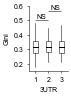

In [99]:
col = 'Merged_3utr_gini'
plt.figure(figsize = (0.7 , 1.2))
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':'0.5'},
    'medianprops':{'color':'k', 'linewidth':'1'},
    'whiskerprops':{'color':'k', 'linewidth':'0.5'},
    'capprops':{'color':'k', 'linewidth' :0}
}

sns.boxplot(x = 'Ribo_cluster',y = col, data=df[df['Merged_5utr_AC350'] >= 20], 
            width=0.35, showfliers = False, **PROPS, order = ['ribo1', 'ribo2', 'ribo3'])

ax = plt.gca()
ax.spines['top'].set_linewidth(0)  
ax.spines['right'].set_linewidth(0) 
ax.grid(False)

plt.xticks([0,1,2], ['1', '2', '3'])
plt.yticks([0.2, 0.3, 0.4, 0.5, 0.6])
plt.ylim(0.15, 0.6)
# plt.xlim(-0.8, 2.5)

plt.ylabel('Gini')
plt.xlabel('3UTR')

def plot_sig(xstart,xend, yend, sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')

plot_sig(0, 1, 0.50, 'NS')
plot_sig(1, 2, 0.56, 'NS')
plt.savefig('5_Figure/fig3_boxplot_riboCluster_3UTRgini_distribution.pdf',  bbox_inches = 'tight')
plt.show()

## RNA abundance and structure --> CCW22

In [5]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')
df.loc[df['Meiosis_specific'] != 'yes', 'Meiosis_specific'] = 'no'

In [6]:
tpsPost6h = ['RNA_6h','RNA_7h','RNA_7h25','RNA_7h5','RNA_8h25','RNA_8h75','RNA_9h5']
df['RNA_log2avgPost6h'] =np.log2(df[['RNA_6h','RNA_7h','RNA_7h25','RNA_7h5','RNA_8h25','RNA_8h75','RNA_9h5']].mean(axis = 1))

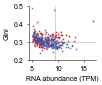

In [291]:

fig, ax = plt.subplots(figsize = (1.2 , 1))

dfplot = df.loc[((df.Ribo_cluster == 'ribo3')) & (df.RNA_log2avgPost6h >= 5)]
plt.scatter(dfplot['RNA_log2avgPost6h'], dfplot['Merged_Gene_gini'], s = 0.5, edgecolors=None, 
            color = '#ED2224', alpha = 1)

dfplot = df.loc[~(df.Ribo_cluster == 'ribo3')]
dfplot = dfplot.loc[(dfplot.Ribo_cluster == 'ribo2') & (dfplot.RNA_log2avgPost6h >= 5)]
plt.scatter(dfplot['RNA_log2avgPost6h'], dfplot['Merged_Gene_gini'], s = 0.5, edgecolors=None, 
            color = '#3A53A4', alpha = 0.7)

plt.axhline(y = 0.30, color='gray', linestyle='--', lw = 0.5)
plt.axvline(x = 9.5, color='gray', linestyle='--', lw = 0.5)

plt.ylim(0.2, 0.5)
plt.xlabel('RNA abundance (TPM)')
plt.ylabel('Gini')
plt.savefig('5_Figure/fig3-RNA abundeance ribo and structure.pdf',  bbox_inches = 'tight')
plt.show()

### GFP reporter assay

In [217]:
df1 = pd.read_excel('3_Table/CLB3 ATG40 SPS1 raw data.xlsx', sheet_name='GFP_repoter_assay', index_col=0)

In [218]:
df2 = df1 - df1.min(axis = 0)
df2 = df2/df2.max(axis = 0)

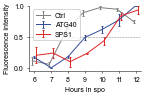

In [288]:
# plt.figure(figsize=(1.8, 1.2))
fig, ax = plt.subplots(figsize=(2, 1.2))

trans1 = ax.transData + ScaledTranslation(-2/72, 0, fig.dpi_scale_trans)
trans2 = ax.transData + ScaledTranslation(+2/72, 0, fig.dpi_scale_trans)

# df2[[i for i in df2.columns if i.startswith('CTRL')]].mean(axis = 1).plot(label = 'Ctrl', color = 'gray', linestyle = '--')
plt.errorbar(df2.index, df2[[i for i in df2.columns if i.startswith('CTRL')]].mean(axis = 1),\
             df2[[i for i in df2.columns if i.startswith('CTRL')]].apply(np.std, axis = 1)/np.sqrt(3), \
             color = 'gray', elinewidth = 1, capsize=1, capthick = 1, 
             label = 'Ctrl', transform=trans1) # 

# df2[[i for i in df2.columns if i.startswith('ATG40')]].mean(axis = 1).plot(label = 'ATG40', color = 'gray', linestyle = '--')
plt.errorbar(df2.index, df2[[i for i in df2.columns if i.startswith('ATG40')]].mean(axis = 1),\
             df2[[i for i in df2.columns if i.startswith('ATG40')]].apply(np.std, axis = 1)/np.sqrt(3), \
             color = '#374F9A', elinewidth = 1, capsize=1, capthick = 1, label = 'ATG40') # 

# df2[[i for i in df2.columns if i.startswith('SPS1')]].mean(axis = 1).plot(label = 'SPS1', color = 'gray', linestyle = '--')
plt.errorbar(df2.index, df2[[i for i in df2.columns if i.startswith('SPS1')]].mean(axis = 1),\
             df2[[i for i in df2.columns if i.startswith('SPS1')]].apply(np.std, axis = 1)/np.sqrt(3), \
             color = '#DE2925', elinewidth = 1, capsize=1, capthick = 1, label = 'SPS1', transform=trans2) # 



plt.legend()

plt.axhline(y = 0.50, color='gray', linestyle='--', lw = 0.5)
plt.ylim(-0.05, 1)
plt.xticks([6,7,8,9,10,11,12])
plt.xlabel('Hours in spo')
plt.ylabel('Fluorescence intensity')
plt.savefig('5_Figure/fig3-SPS1 fluorescence intensity.pdf',  bbox_inches = 'tight')
plt.show()

## ATG40

In [82]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')
dftps = pd.read_table('3_Table/shapemapper_all9Normalized_transcripts_3utr.txt')

In [86]:
def fetch_gene_reactivities_2map(gene):
    # CTS2
    dft = dftps[dftps.Gene == gene]

    # 截取depth > 350的区域
    start = dft.loc[dft.depth > 350, 'relative_site'].min()
    end = dft.loc[dft.depth > 350, 'relative_site'].max()
    dft1 = dft[(dft.relative_site >= start) & (dft.relative_site <= end)]
    dft1 = dft1[['Reactivity_norby90_95quantile', 'Stderr_norby90_95quantile', 'Sequence']]
    dft1 = dft1.reset_index(drop = True)
    dft1.index = dft1.index + 1
    dft1.loc[dft1.Sequence.isin(['G', 'U']), 'Reactivity_norby90_95quantile'] = -999
    dft1.loc[dft1.Sequence.isin(['G', 'U']), 'Stderr_norby90_95quantile'] = -999
    dft1 = dft1.fillna(-999)
    dft1.to_csv('3_Table/delayed example/' + df.loc[gene, 'GENE_name'] + '_'+ str(int(start)) + '_' + str(int(end)) + '.map', header=None, sep = '\t')
    
    dft1['pos'] = dft1.index
    dft1 = dft1[['pos', 'Reactivity_norby90_95quantile']]
    dft1['Reactivity_norby90_95quantile'] = dft1['Reactivity_norby90_95quantile'] + 0.01
    dft1.loc[dft1.Reactivity_norby90_95quantile < 0, 'Reactivity_norby90_95quantile'] = 0
    dft1[['pos', 'Reactivity_norby90_95quantile']].to_csv('3_Table/delayed example/' + df.loc[gene, 'GENE_name'] + '_'+ str(int(start)) + '_' + str(int(end)) + '.shape', sep = '\t', header=None, index=None)

In [87]:
genes = ['YOR152C']
# ['ATG40']
for gene in genes:
    fetch_gene_reactivities_2map(gene)

In [90]:
genes = ['YGR225W', 'YDR371W', 'YIL045W', 'YPL021W', 'YNR034W', 'YOR355W', 'YOR152C']
for gene in genes:
    print('python Superfold.py ' +  df.loc[gene, 'GENE_name'] + '_all.map' + ' --maxPairingDist 1000')

python SuperFold.py AMA1_all.map --maxPairingDist 1000
python SuperFold.py CTS2_all.map --maxPairingDist 1000
python SuperFold.py PIG2_all.map --maxPairingDist 1000
python SuperFold.py ECM23_all.map --maxPairingDist 1000
python SuperFold.py SOL1_all.map --maxPairingDist 1000
python SuperFold.py GDS1_all.map --maxPairingDist 1000
python SuperFold.py ATG40_all.map --maxPairingDist 1000


In [ ]:
# start: 151
# end: 921

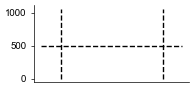

In [108]:
plt.figure(figsize=(2,1))
plt.hlines(y = 500, xmin = 0, xmax = 1063, color = 'k', linestyle = '--')
plt.vlines(x = 151, ymin = 0, ymax = 1063, color = 'k', linestyle = '--')
plt.vlines(x = 921, ymin = 0, ymax = 1063, color = 'k', linestyle = '--')
plt.xticks([])
plt.savefig('5_Figure/Sub Fig3-g ccw22 gene length.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# len(".................((((......(((((..(((((...............)))))....))))).....))))")
# len('UUAUAUCAUUUCGAUUUCAUUUAAUUUGAUCUGGCUCGACAUUAGUAUUUCAAAUCGAGGAUAAGAUUUUUGUAGUG')

In [125]:
dft1[(dft1.relative_site >= -133) & (dft1.relative_site <= -74)]['Sequence'].to_list()

'CAUUUAAUUUGAUCUGGCUCGACAUUAGUAUUUCAAAUCGAGGAUAAGAUUUUUGUAGUG'

In [131]:
dft = dftps[(dftps.Gene == 'YOR152C') & (dftps.relative_site >= -133) & (dftps.relative_site <= -74) ]
dft1 = dft[['Reactivity_norby90_95quantile', 'Stderr_norby90_95quantile', 'Sequence']]
dft1 = dft1.reset_index(drop = True)
dft1.index = dft1.index + 1
dft1.loc[dft1.Sequence.isin(['G', 'U']), 'Reactivity_norby90_95quantile'] = -999
dft1.loc[dft1.Sequence.isin(['G', 'U']), 'Stderr_norby90_95quantile'] = -999
dft1 = dft1.fillna(-999)

dft1['pos'] = dft1.index
dft1 = dft1[['pos', 'Reactivity_norby90_95quantile']]
dft1['Reactivity_norby90_95quantile'] = dft1['Reactivity_norby90_95quantile'] + 0.01
dft1.loc[dft1.Reactivity_norby90_95quantile < 0, 'Reactivity_norby90_95quantile'] = 0
dft1[['pos', 'Reactivity_norby90_95quantile']].to_csv('3_Table/delayed example/' + df.loc[gene, 'GENE_name'] + '_-133_-74' + '.shape', sep = '\t', header=None, index=None)

## disrupted CCW22 delay meiosis

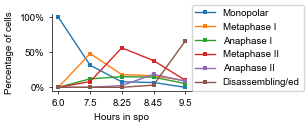

In [62]:
dfwt = pd.read_excel('3_Table/DED1 CCW22 disruption/IF counts_CCW22_summary.xlsx', sheet_name='ccw22_wt')
dfwt['Timepoints'] = dfwt.index
dfwtl = dfwt.melt(['Timepoints','Time'])

plt.figure(figsize = (1.8, 1))
sns.lineplot(x = 'Timepoints', y = 'value', hue = 'variable', data = dfwtl, marker = 's', mew = 0)
plt.xticks([0,1,2,3,4], dfwt['Time'])
plt.xlabel('Hours in spo')
plt.ylabel('Percentage of cells')
plt.yticks([0, 0.5,  1], ['0%',  '50%', '100%'])
plt.legend(loc = [1,0])
plt.savefig('5_Figure/Sub Fig3-i ccw22 disrupted IF counts_WT.pdf', bbox_inches = 'tight')
plt.show()

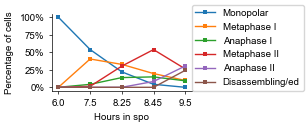

In [63]:
dfwt = pd.read_excel('3_Table/DED1 CCW22 disruption/IF counts_CCW22_summary.xlsx', sheet_name='ccw22_sm')
dfwt['Timepoints'] = dfwt.index
dfwtl = dfwt.melt(['Timepoints','Time'])

plt.figure(figsize = (1.8, 1))
sns.lineplot(x = 'Timepoints', y = 'value', hue = 'variable', data = dfwtl, marker = 's', mew = 0)
plt.xticks([0,1,2,3,4], dfwt['Time'])
plt.xlabel('Hours in spo')
plt.ylabel('Percentage of cells')
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0%', '25%', '50%', '75%', '100%'])
plt.legend(loc = [1,0])
plt.savefig('5_Figure/Sub Fig3-i ccw22 disrupted IF counts_SM.pdf', bbox_inches = 'tight')
plt.show()

# Fig4 Translation resources and Helicases

In [ ]:
#FFCE2E yellow
#A1C9F4 blue
#FF9F9B red
#CFCFCF gray

### Translation resources

In [381]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')
df.loc[df['Meiosis_specific'] != 'yes', 'Meiosis_specific'] = 'no'

In [382]:
tps1 = ['YPD', '0h', '6h', '7h','7h25', '7h5','8h25', '8h75', '9h5']
matchup = {'YPD':'YPD', '0h': '0h', '6h':'6h', '7h':'7h', '7h25':'7h25', '7h5':'7h5', '8h25':'8h', '8h75': '8h5', '9h5':'9h25'}
tps = ['Ribo_brar_' + matchup[i] for i in tps1]

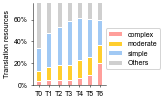

In [383]:
# Meiosis_specific RNAs ranked by structure
dfRibo = df[tps + ['Merged_Gene_gini', 'Meiosis_specific']]
dfRibo.columns = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'rank', 'meiotic']
t = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
dfRibo['rank'] = dfRibo.loc[(dfRibo.meiotic == 'yes'), 'rank'].rank()/dfRibo.loc[(dfRibo.meiotic == 'yes'), 'rank'].dropna().shape[0]

dfRibo['grank'] = 'Others'
dfRibo.loc[(dfRibo['rank'] >= 0 ) & (dfRibo.meiotic == 'yes'), 'grank'] = 'simple'
dfRibo.loc[(dfRibo['rank'] >= 1/3)& (dfRibo.meiotic == 'yes'), 'grank'] = 'moderate'
dfRibo.loc[(dfRibo['rank'] >= 2/3)& (dfRibo.meiotic == 'yes'), 'grank'] = 'complex'

# sum the ribo translation resources
dfb = dfRibo.groupby('grank').sum()[t]/dfRibo.sum()[t]

width = 0.5
plt.figure(figsize=(1.3, 1.5))
plt.bar(dfb.columns, dfb.loc['complex'], label = 'complex', color = '#FF9F9B', width=width, edgecolor='white')

plt.bar(dfb.columns, dfb.loc['moderate'], bottom=dfb.loc['complex'], 
        label = 'moderate', color = '#FFCE2E', width=width, edgecolor='white')

plt.bar(dfb.columns, dfb.loc['simple'],bottom=dfb.loc['complex']+ dfb.loc['moderate'], 
        label = 'simple', color = '#A1C9F4', width=width, edgecolor='white')

plt.bar(dfb.columns, dfb.loc['Others'],bottom=dfb.loc['complex']+ dfb.loc['moderate']+dfb.loc['simple'],
        label = 'Others', color = '#CFCFCF', width=width, edgecolor='white')

plt.yticks([0, 0.2, 0.4, 0.6], ['0%', '20%', '40%', '60%'])
plt.ylabel('Translation resources')
plt.ylim(0, 0.75)
plt.legend(loc = (1,0.2))

# plt.savefig('5_Figure/fig4-a translation resource allocation among meiosis specific RNAs.pdf',  bbox_inches = 'tight')
plt.show()

### global Helicase 

In [334]:
dfheli_compute = pd.read_table('3_Table/RNA_helicase_activity_annotations_Computational.txt')
dfheli_compute = dfheli_compute.drop_duplicates('Systematic Name/Complex Accession')
dfheli_compute = dfheli_compute.set_index('Systematic Name/Complex Accession')

dfheli_manually = pd.read_table('3_Table/RNA_helicase_activity_annotations_Manually.txt')
dfheli_manually = dfheli_manually.drop_duplicates('Systematic Name/Complex Accession')
dfheli_manually = dfheli_manually.set_index('Systematic Name/Complex Accession')

helicases = set((dfheli_manually.index.to_list() + dfheli_compute.index.to_list()))
helicases = [i for i in helicases if i.startswith('Y')]
helicaccessory = ['YPR163C', 'YGL049C', 'YDR429C', 'YGR162W', 'YOL139C', 'YMR146C']
# ['TIF3', 'TIF4632', 'TIF35', 'TIF4631', 'CDC33', 'TIF34']
# helicaccessory = ['YPR163C', 'YGL049C', 'YGR162W']

helicases = helicases + helicaccessory

In [336]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')
tps = ['YPD', '0h', '6h', '7h','7h25', '7h5','8h25', '8h75', '9h5']
matchup = {'YPD':'YPD', '0h': '0h', '6h':'6h', '7h':'7h', '7h25':'7h25', '7h5':'7h5', '8h25':'8h', '8h75': '8h5', '9h5':'9h25'}

In [337]:
ritps = ['Ribo_brar_' + matchup[i] for i in tps[2:]]
dfheri = df.loc[helicases, ['GENE_name']+[i for i in df.columns if i.startswith('Ribo_brar')][2:]]

dfheri = dfheri.set_index('GENE_name')

In [340]:
df3 = pd.read_table('3_Table/helicase cluster/helicase_ribo_maxover10.cdt')['NAME'].dropna()

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


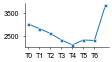

In [455]:
ritps = ritps + ['Ribo_brar_11h']
plt.figure(figsize=(1.3/6*7, 0.8))
sns.lineplot(dfheri.loc[df3, ritps].sum().index, dfheri.loc[df3, ritps].sum().values, marker = 's', markeredgewidth = 0.5)
plt.xticks([0,1,2,3,4,5,6], ['T0','T1','T2','T3','T4','T5','T6'])
# plt.ylim(1000,4000)
plt.yticks([2500, 3500])
# plt.savefig('5_Figure/fig4-b helicase_all_Ribo_11h.pdf', bbox_inches = 'tight')
plt.show()

### Ded1 overexpression

In [30]:
df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx', index_col='GENE_ID')

In [23]:
df1 = pd.read_csv('3_Table/MS/d8h75vs8h75.csv', index_col=0)
df1['FC'] = 2**df1['logFC']

In [31]:
fc = 1.2 
logfc = 0.2

df1['color'] = np.nan
df1['logp_adj'] = -np.log10(df1['adj.P.Val'])

genes1 = df1[(df1['adj.P.Val'] < 0.05) & (df1['FC'] > fc)].index
genes2 = df1[(df1['adj.P.Val'] < 0.05) & (df1['FC'] < 1/fc)].index
genes3 = df1[~df1.index.isin(genes1.to_list() + genes2.to_list())].index

df1.loc[[i for i in genes1 if i in df.index], 'color'] = 'Up-'
df1.loc[[i for i in genes2 if i in df.index], 'color'] = 'Down-'
df1.loc[[i for i in genes3 if i in df.index], 'color'] = 'NS'

/var/folders/rw/85k6y2vs37x81n21hjm129fm0000gn/T/ipykernel_14118/1587878080.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Up-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.loc[[i for i in genes1 if i in df.index], 'color'] = 'Up-'


In [32]:
print(len(genes1),len(genes2), len(genes3))

149 194 2761


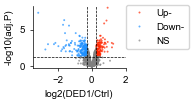

In [33]:
plt.figure(figsize = (1.2, 0.8))
ax = sns.scatterplot(x = 'logFC', y = 'logp_adj', hue = 'color', palette=['#FF2701','dodgerblue','gray'],
                data = df1.dropna(), alpha = 0.7, linewidth = 0, s = 2)


plt.axhline(y = -np.log10(0.05), color='k', linestyle='--', lw = 0.5)
plt.axvline(x = np.log2(1.2), color='k', linestyle='--', lw = 0.5)
plt.axvline(x = -np.log2(1.2), color='k', linestyle='--', lw = 0.5)


plt.legend(loc = (1,0.3))

plt.xlim(-3.5,2)
plt.ylim(-0.2, 8.2)
# ax = plt.gca()#获取边框
# spwidth = 1
# ax.spines['top'].set_linewidth(spwidth)  
# ax.spines['right'].set_linewidth(spwidth) 
# ax.spines['bottom'].set_linewidth(spwidth)
# ax.spines['left'].set_linewidth(spwidth)
plt.xlabel('log2(DED1/Ctrl)')
plt.ylabel('-log10(adj.P)')

# plt.savefig('5_Figure/fig4-f volcano_ded1vsCtrl.pdf', bbox_inches = 'tight')
plt.show()

up vs down MannwhitneyuResult(statistic=15574.0, pvalue=5.861999809641358e-06)
up vs others MannwhitneyuResult(statistic=165164.0, pvalue=0.2477022095851259)
others vs down MannwhitneyuResult(statistic=182376.0, pvalue=2.8745620236248536e-07)


/var/folders/rw/85k6y2vs37x81n21hjm129fm0000gn/T/ipykernel_14118/1461076170.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'up' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[[i for i in genes1 if i in df.index], 'ded1'] = 'up'


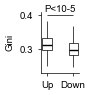

In [42]:
# up vs down, 1.2 fold change
fc = 1.2

genes1 = df1[(df1['adj.P.Val'] < 0.05) & (df1['FC'] > fc)].index
genes2 = df1[(df1['adj.P.Val'] < 0.05) & (df1['FC'] < 1/fc)].index
genes3 = df1[~df1.index.isin(genes2.to_list()+genes1.to_list())].index

df['ded1'] = np.nan
df.loc[[i for i in genes1 if i in df.index], 'ded1'] = 'up'
df.loc[[i for i in genes2 if i in df.index], 'ded1'] = 'down'
df.loc[[i for i in genes3 if i in df.index], 'ded1'] = 'others'

plt.figure(figsize = (0.5, 0.8))

col = 'Merged_Gene_gini'
dfplot = df[df['Merged_Gene_gini'] >0]
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':0.5},
    'medianprops':{'color':'k', 'linewidth':1},
    'whiskerprops':{'color':'k', 'linewidth':0.5},
    'capprops':{'color':'k', 'linewidth' :0}
}


# cut off 45, 0.007
print('up vs down', stats.mannwhitneyu(dfplot.loc[dfplot.ded1 == 'up', col].dropna(), dfplot.loc[dfplot.ded1 == 'down', col].dropna()))
print('up vs others', stats.mannwhitneyu(dfplot.loc[dfplot.ded1 == 'up', col].dropna(), dfplot.loc[dfplot.ded1 == 'others', col].dropna()))
print('others vs down', stats.mannwhitneyu(dfplot.loc[dfplot.ded1 == 'down', col].dropna(), dfplot.loc[dfplot.ded1 == 'others', col].dropna()))

ax = sns.boxplot(x = 'ded1', y = col, data = dfplot, width=0.35,showfliers = False,\
         **PROPS, order=['up', 'down'])




def plot_sig(xstart,xend, yend, sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')

plot_sig(0, 1, 0.40, 'P<10-5')

plt.ylim(0.23, 0.41)
plt.xlabel(None)
plt.ylabel('Gini')
plt.xticks([0,1], ['Up', 'Down'])
# plt.yticks([])
# plt.savefig('5_Figure/fig4-g boxplot_upvsDown_geneGini.pdf', bbox_inches = 'tight')

plt.show()

In [43]:
print(dfplot.loc[dfplot.ded1 == 'up', col].dropna().shape, \
dfplot.loc[dfplot.ded1 == 'down', col].dropna().shape)

(126,) (190,)


### Ded1, elF4a and elF4b

In [25]:
dfhlx_ms = pd.read_excel('3_Table/helicase cluster/Helicase.xlsx', \
    index_col=0)
dfhlx_ms = dfhlx_ms[[i for i in dfhlx_ms.columns \
    if i.startswith('A14201')]]
dfhlx_ms.columns = ['T0', 'T2', 'T5', 'T6', '12h']
tp4 = ['T0', 'T2', 'T5', 'T6']

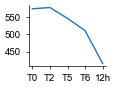

In [30]:
plt.plot(dfhlx_ms.loc['DED1'])

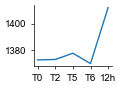

In [31]:
plt.plot(dfhlx_ms.loc['TIF1'])

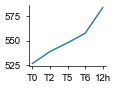

In [32]:
plt.plot(dfhlx_ms.loc['TIF3'])